In [7]:
# Cargar modelo entrenado
import joblib, os
model_path = "../models/final_model.pkl"
if os.path.exists(model_path):
    search = joblib.load(model_path)
    print("Modelo cargado desde", model_path)
else:
    print("⚠️ No se encontró", model_path, "- ejecuta 03_Entrenamiento.ipynb primero para generar el modelo.")

Modelo cargado desde ../models/final_model.pkl


In [8]:
# === CAMBIO 1: Setup reproducible + utilidades ===
import os, json, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime
import joblib

# Reproducibilidad (evita sorpresas en re-ejecuciones)
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(42)

# Carpeta donde guardaremos artefactos (gráficas, json, modelos, etc.)
OUT = Path("artifacts")
OUT.mkdir(exist_ok=True)

def dump_json(obj, path):
    """Guarda un dict/objeto como JSON bonito (UTF-8, identado)."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# Log rápido de entorno (útil para reproducibilidad)
VERSIONS = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "python": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
    "numpy": np.__version__,
    "pandas": pd.__version__,
}
try:
    import sklearn, scipy
    VERSIONS.update({
        "scikit_learn": sklearn.__version__,
        "scipy": scipy.__version__,
    })
except Exception:
    pass

dump_json(VERSIONS, OUT / "env_versions.json")
print("OK: entorno inicializado. Artefactos en:", OUT.resolve())


OK: entorno inicializado. Artefactos en: C:\Users\pc\Documents\Proyecto Final\notebooks\artifacts


In [9]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("./../data/df_model_prepared.csv")  # ajusta si tu ruta es otra
df = pd.read_csv(DATA_PATH, sep=";")

# Tipado: categóricas a 'category', numéricas a número
cat_cols = ["Product","Sub-product","Issue","Sub-issue","State","Company","Company response"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")


df["Timely response?"] = df["Timely response?"].astype("int8")

# target: 0/1 -> int8 (sobra)
df["target"] = df["target"].astype("int8")

# days_to_company: 0..10 -> uint8 (entero sin signo, ocupa menos)
df["days_to_company"] = df["days_to_company"].astype("uint8")

df.shape, df.dtypes


((4678, 10),
 Product             category
 Sub-product         category
 Issue               category
 Sub-issue           category
 State               category
 Company             category
 Company response    category
 Timely response?        int8
 days_to_company        uint8
 target                  int8
 dtype: object)

In [10]:
print("Problema: Clasificación binaria (predecir 'target' 0/1)")

vc = df["target"].value_counts().sort_index()
print("\nDistribución target:")
print(vc)
print(f"\nRatio positivos (1): {df['target'].mean():.3f}")


Problema: Clasificación binaria (predecir 'target' 0/1)

Distribución target:
target
0    1076
1    3602
Name: count, dtype: int64

Ratio positivos (1): 0.770


In [11]:
# === Split recomendado: Train/Test (CV interno para validación) ===
from sklearn.model_selection import train_test_split
import pandas as pd

TARGET = "target"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Shapes -> train:", X_train.shape, "| test:", X_test.shape)
print("Ratios de positivos -> train:", y_train.mean(), "| test:", y_test.mean())


Shapes -> train: (3742, 9) | test: (936, 9)
Ratios de positivos -> train: 0.7699091394975949 | test: 0.7702991452991453


In [12]:
# === Preprocesamiento columnas ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import inspect

# Columnas por tipo
cat_cols = X_train.select_dtypes(include=["category"]).columns.tolist()
num_cols = [c for c in X_train.select_dtypes(include=["number"]).columns if c not in ["target", "Timely response?"]]
bin_cols = [c for c in ["Timely response?"] if c in X_train.columns]

# OneHotEncoder con fallback y salida densa
ohe_kwargs = {"handle_unknown": "ignore"}
if "min_frequency" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["min_frequency"] = 0.01  # agrupa categorías muy raras
# salida densa (nombre depende de versión)
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(**ohe_kwargs))
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe, num_cols),
        ("bin", "passthrough", bin_cols),
    ],
    remainder="drop",
    n_jobs=-1
)

preprocess

,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [13]:
!pip install xgboost lightgbm

In [14]:
# === Leaderboard ===
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, average_precision_score
import numpy as np
import pandas as pd

# --- Métricas y CV ---
SCORING = {
    "roc_auc": "roc_auc",
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "ap": make_scorer(average_precision_score, needs_threshold=True)  # PR AUC
}
cv_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
primary_metric = "roc_auc"

# --- Modelos base ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "LinearSVC": LinearSVC(class_weight="balanced", random_state=42)
}

# --- XGBoost y LightGBM ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models["XGBoost"] = XGBClassifier(
    eval_metric="logloss", random_state=42, n_jobs=-1,
    tree_method="hist"  # rápido y robusto
)
models["LightGBM"] = LGBMClassifier(random_state=42, n_jobs=-1)

# --- Pipelines usando TU 'preprocess' ya definido ---
pipelines = {name: Pipeline([("prep", preprocess), ("model", mdl)]) for name, mdl in models.items()}

# --- Cross-validate todos y crear leaderboard ---
rows, errors = [], []
for name, pipe in pipelines.items():
    try:
        cvres = cross_validate(
            pipe, X_train, y_train,
            cv=cv_, scoring=SCORING, n_jobs=-1, return_train_score=False
        )
        row = {"model": name, "fit_time": np.mean(cvres["fit_time"])}
        for k in SCORING.keys():
            row[f"{k}_mean"] = float(np.mean(cvres[f"test_{k}"]))
            row[f"{k}_std"]  = float(np.std(cvres[f"test_{k}"]))
        rows.append(row)
    except Exception as e:
        errors.append((name, repr(e)))

leaderboard = pd.DataFrame(rows).sort_values(f"{primary_metric}_mean", ascending=False).reset_index(drop=True)
print("Modelos con error:", errors if errors else "ninguno")
leaderboard


Modelos con error: ninguno


,model,fit_time,roc_auc_mean,roc_auc_std,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std,ap_mean,ap_std
0,XGBoost,0.520068,0.663136,0.018704,0.857687,0.005329,0.792886,0.005607,0.934048,0.006790,NaN,NaN
1,GBDT,0.560228,0.661625,0.026650,0.868928,0.002546,0.778151,0.003111,0.983686,0.001773,NaN,NaN
2,LightGBM,0.332345,0.657318,0.021374,0.860481,0.003379,0.789055,0.005328,0.946197,0.006957,NaN,NaN
3,RandomForest,0.304006,0.651710,0.013724,0.845287,0.002408,0.792552,0.003146,0.905585,0.006313,NaN,NaN
4,LogReg,0.088037,0.645281,0.026868,0.866347,0.004404,0.780623,0.001913,0.973271,0.009862,NaN,NaN
5,LinearSVC,0.052260,0.640993,0.022307,0.714113,0.014239,0.837146,0.014584,0.622693,0.015256,NaN,NaN
6,KNN,0.043916,0.591527,0.015560,0.844857,0.005968,0.786090,0.003493,0.913226,0.012979,NaN,NaN
7,DecisionTree,0.085851,0.579833,0.017137,0.782293,0.008571,0.807784,0.008401,0.758414,0.010737,NaN,NaN


Resumen test:
  model: RandomForest
  test_roc_auc: 0.7092
  test_ap: 0.8855
  f1@0.5: 0.7579
  precision@0.5: 0.8566
  recall@0.5: 0.6796
  threshold_opt_f1: 0.3000
  f1@opt: 0.8722
  precision@opt: 0.7828
  recall@opt: 0.9847


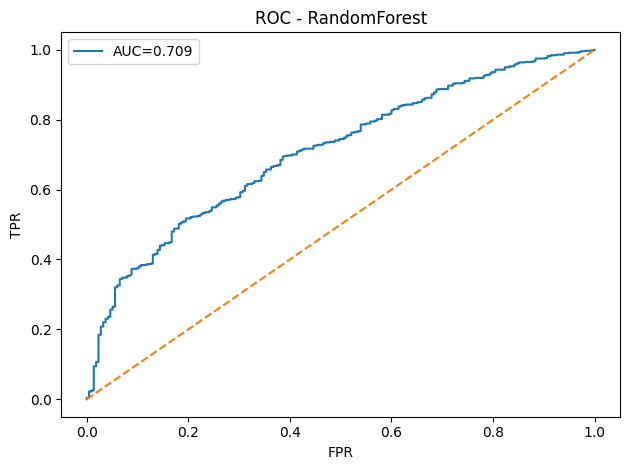

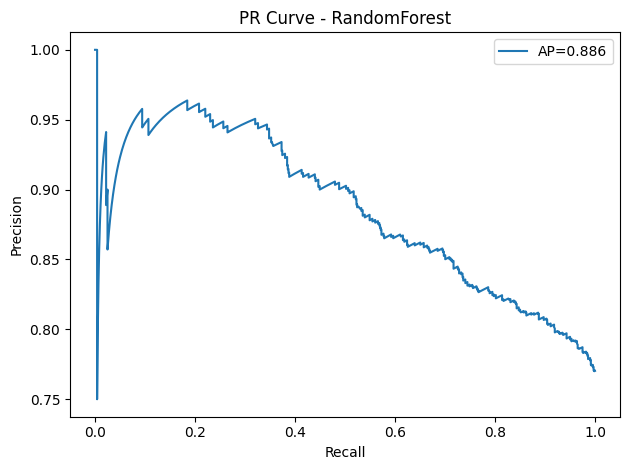

<Figure size 640x480 with 0 Axes>

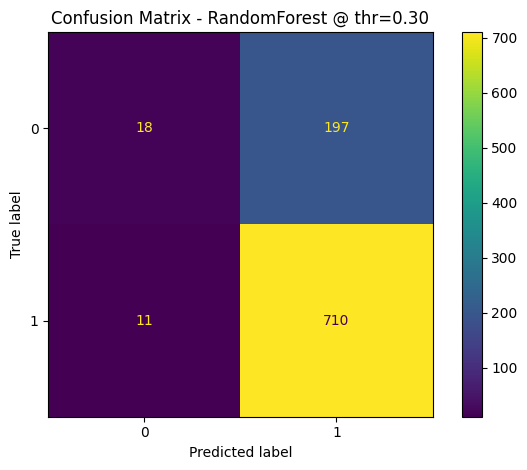


Imágenes guardadas en: C:\Users\pc\Documents\Proyecto Final\notebooks\artifacts


In [15]:
# === EVALUACIÓN EN TEST DEL MEJOR + GRÁFICAS ===
import json, joblib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

OUT = Path("artifacts"); OUT.mkdir(exist_ok=True)

# --- cargar el mejor (si no viene en memoria de la celda anterior) ---
try:
    best_model, best_name
except NameError:
    meta = json.load(open(OUT / "best_overall.json", "r", encoding="utf-8"))
    best_name = meta["best_name"]
    best_model = joblib.load(OUT / f"pipeline_best_{best_name.lower()}.joblib")

# --- helper para obtener score continuo ---
def get_scores(est, X):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        return est.decision_function(X)
    # último recurso: etiqueta binaria como score (no ideal para AUC/AP)
    return est.predict(X).astype(float)

y_score = get_scores(best_model, X_test)
y_pred_05 = (y_score >= 0.5).astype(int)

# --- umbral óptimo por F1 ---
thresholds = np.linspace(0.05, 0.95, 19)
f1_vals = [metrics.f1_score(y_test, (y_score >= t).astype(int)) for t in thresholds]
t_opt = thresholds[int(np.argmax(f1_vals))]
y_pred_opt = (y_score >= t_opt).astype(int)

# --- métricas resumen (0.5 y umbral óptimo) ---
summary = {
    "model": best_name,
    "test_roc_auc": float(metrics.roc_auc_score(y_test, y_score)),
    "test_ap": float(metrics.average_precision_score(y_test, y_score)),
    "f1@0.5": float(metrics.f1_score(y_test, y_pred_05)),
    "precision@0.5": float(metrics.precision_score(y_test, y_pred_05)),
    "recall@0.5": float(metrics.recall_score(y_test, y_pred_05)),
    "threshold_opt_f1": float(t_opt),
    "f1@opt": float(metrics.f1_score(y_test, y_pred_opt)),
    "precision@opt": float(metrics.precision_score(y_test, y_pred_opt)),
    "recall@opt": float(metrics.recall_score(y_test, y_pred_opt)),
}
print("Resumen test:")
for k, v in summary.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# --- ROC ---
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {best_name}")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / f"roc_{best_name}.png", dpi=160)
plt.show()

# --- Precision-Recall ---
prec, rec, _ = metrics.precision_recall_curve(y_test, y_score)
ap = metrics.average_precision_score(y_test, y_score)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve - {best_name}")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / f"pr_{best_name}.png", dpi=160)
plt.show()

# --- Matriz de confusión (con umbral óptimo) ---
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)
plt.title(f"Confusion Matrix - {best_name} @ thr={t_opt:.2f}")
plt.tight_layout()
plt.savefig(OUT / f"cm_{best_name}_thr{t_opt:.2f}.png", dpi=160)
plt.show()

print(f"\nImágenes guardadas en: {OUT.resolve()}")


Resumen test (rebalanceado):
  model: RandomForest
  test_roc_auc: 0.7092
  test_ap: 0.8855
  f1@0.5: 0.7579
  precision@0.5: 0.8566
  recall@0.5: 0.6796
  threshold_opt_f1: 0.3000
  f1@opt: 0.8722
  precision@opt: 0.7828
  recall@opt: 0.9847


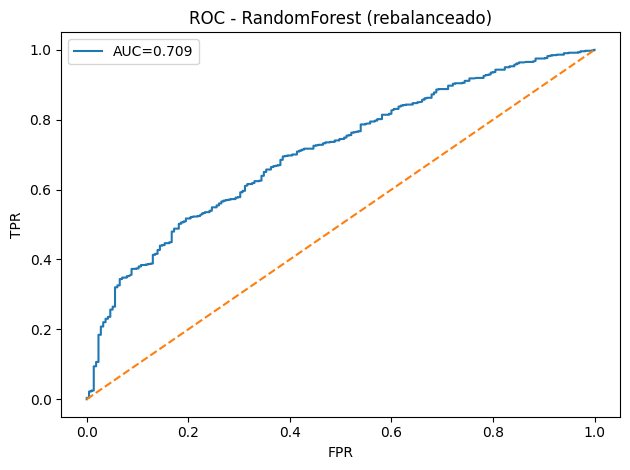

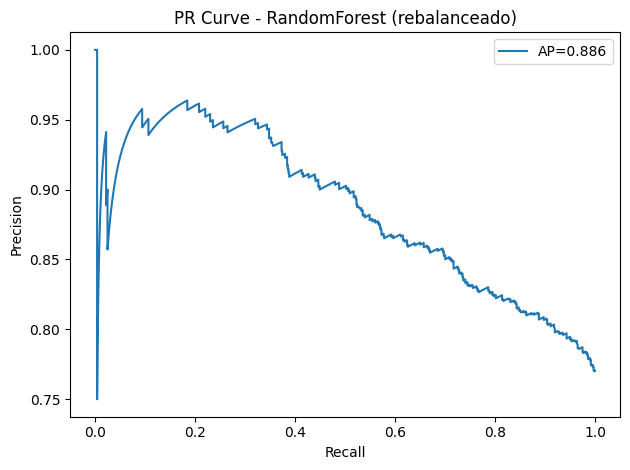

<Figure size 640x480 with 0 Axes>

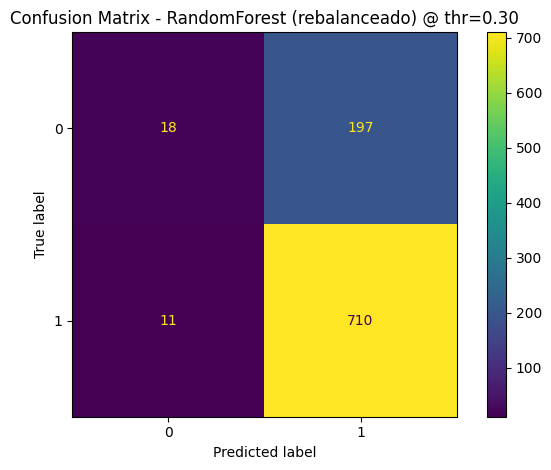


Imágenes guardadas en: C:\Users\pc\Documents\Proyecto Final\notebooks\artifacts


In [16]:
# === TEST DEL MEJOR (rebalanceado) + UMBRAL ÓPTIMO + GRÁFICAS ===
import json, joblib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

OUT = Path("artifacts"); OUT.mkdir(exist_ok=True)

# Cargar el mejor re-balanceado si no está ya en memoria
try:
    best_model, best_name
except NameError:
    meta = json.load(open(OUT / "best_overall_bal.json", "r", encoding="utf-8"))
    best_name = meta["best_name"]
    best_model = joblib.load(OUT / f"pipeline_best_bal_{best_name.lower()}.joblib")

def scores(est, X):
    if hasattr(est, "predict_proba"):    return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"): return est.decision_function(X)
    return est.predict(X).astype(float)   # último recurso

# Scores y baseline @0.5
y_score = scores(best_model, X_test)
y_pred_05 = (y_score >= 0.5).astype(int)

# Umbral óptimo por F1
grid = np.linspace(0.05, 0.95, 19)
f1s = [metrics.f1_score(y_test, (y_score >= t).astype(int)) for t in grid]
t_opt = grid[int(np.argmax(f1s))]
y_pred_opt = (y_score >= t_opt).astype(int)

# Resumen de métricas
summary = {
    "model": best_name,
    "test_roc_auc": float(metrics.roc_auc_score(y_test, y_score)),
    "test_ap": float(metrics.average_precision_score(y_test, y_score)),
    "f1@0.5": float(metrics.f1_score(y_test, y_pred_05)),
    "precision@0.5": float(metrics.precision_score(y_test, y_pred_05)),
    "recall@0.5": float(metrics.recall_score(y_test, y_pred_05)),
    "threshold_opt_f1": float(t_opt),
    "f1@opt": float(metrics.f1_score(y_test, y_pred_opt)),
    "precision@opt": float(metrics.precision_score(y_test, y_pred_opt)),
    "recall@opt": float(metrics.recall_score(y_test, y_pred_opt)),
}
print("Resumen test (rebalanceado):")
for k, v in summary.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ====== Gráficas ======
# ROC
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {best_name} (rebalanceado)")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / f"roc_bal_{best_name}.png", dpi=160)
plt.show()

# Precision-Recall
prec, rec, _ = metrics.precision_recall_curve(y_test, y_score)
ap = metrics.average_precision_score(y_test, y_score)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve - {best_name} (rebalanceado)")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / f"pr_bal_{best_name}.png", dpi=160)
plt.show()

# Matriz de confusión (umbral óptimo)
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)
plt.title(f"Confusion Matrix - {best_name} (rebalanceado) @ thr={t_opt:.2f}")
plt.tight_layout()
plt.savefig(OUT / f"cm_bal_{best_name}_thr{t_opt:.2f}.png", dpi=160)
plt.show()

print(f"\nImágenes guardadas en: {OUT.resolve()}")


In [17]:
!pip install -U imbalanced-learn


Resumen test RF+SMOTE:
  test_roc_auc: 0.7071
  test_ap: 0.8802
  f1@0.5: 0.8319
  precision@0.5: 0.8168
  recall@0.5: 0.8474
  thr_opt_f1: 0.3500
  f1@opt: 0.8728
  precision@opt: 0.7837
  recall@opt: 0.9847


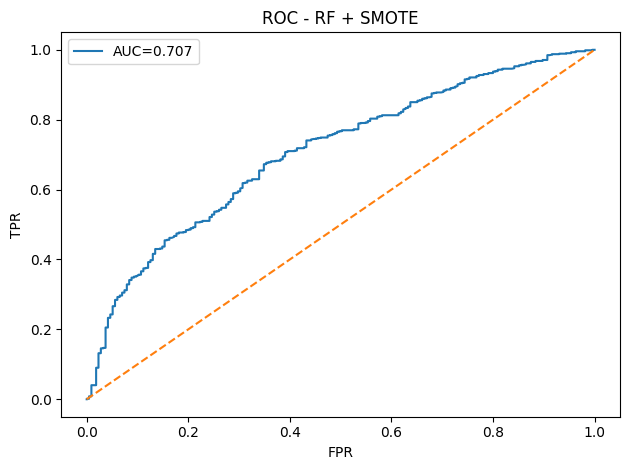

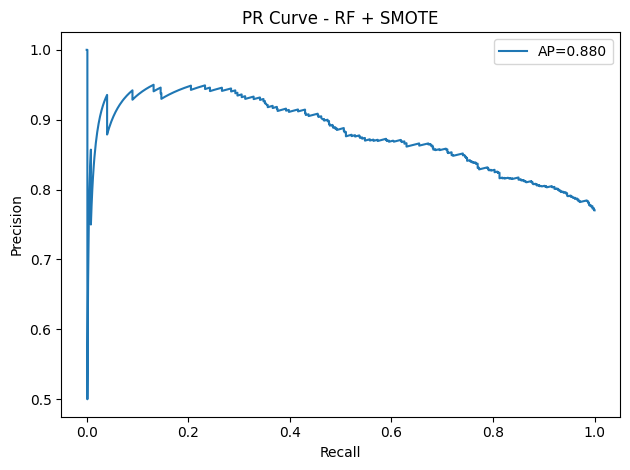

<Figure size 640x480 with 0 Axes>

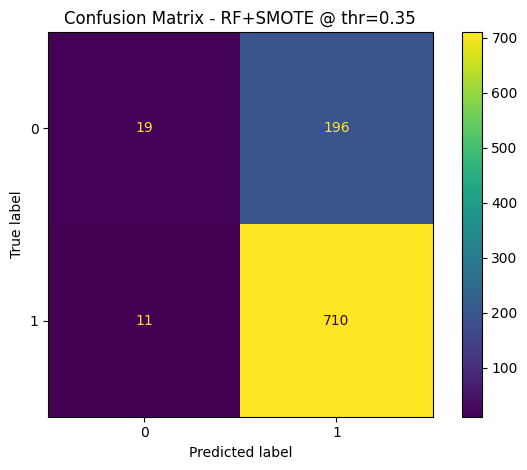


Top 20 importancias (Gini):
                                              feature  importance
0                                num__days_to_company    0.064676
1       cat__Company response_Closed with explanation    0.052917
2                                       cat__State_CA    0.046487
3                       cat__State_infrequent_sklearn    0.031161
4                                       cat__State_TX    0.030078
5                        cat__Company_Bank of America    0.029715
6                 cat__Sub-product_infrequent_sklearn    0.028792
7   cat__Company response_Closed with non-monetary...    0.028288
8                                       cat__State_FL    0.025718
9                     cat__Company_infrequent_sklearn    0.021234
10             cat__Sub-issue_Information is not mine    0.020944
11                                      cat__State_PA    0.018610
12                                      cat__State_OH    0.018429
13                              cat__Product_Mo

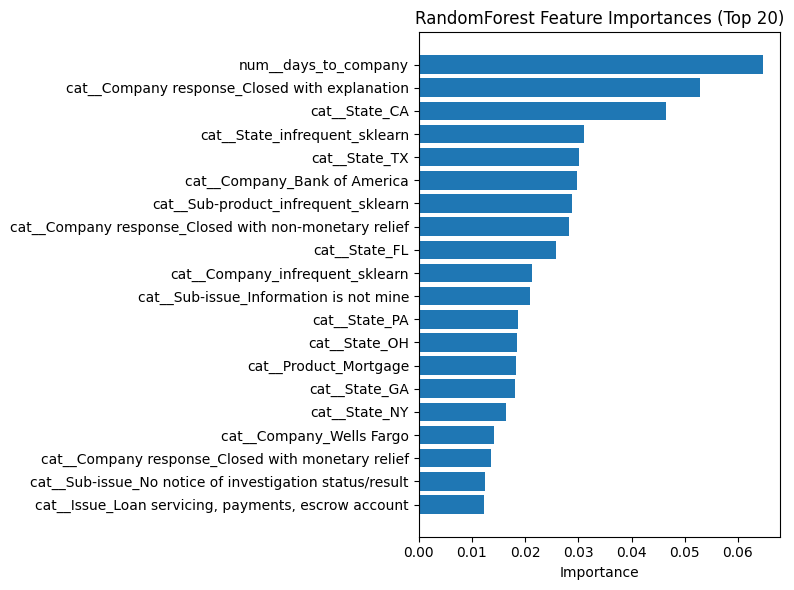


Artefactos guardados en: C:\Users\pc\Documents\Proyecto Final\notebooks\artifacts


In [18]:
# === TEST RF+SMOTE + GRÁFICAS + IMPORTANCIAS ===
import json, joblib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

OUT = Path("artifacts"); OUT.mkdir(exist_ok=True)

# cargar modelo
tag = "rf_smote"
best_model = joblib.load(OUT / f"pipeline_best_{tag}.joblib")

# helper de score continuo
def scores(est, X):
    # el pipeline termina en RandomForest -> tiene predict_proba
    if hasattr(est, "predict_proba"): return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"): return est.decision_function(X)
    return est.predict(X).astype(float)

# ---- métricas base en test ----
y_score = scores(best_model, X_test)
y_pred_05 = (y_score >= 0.5).astype(int)

# Umbral óptimo por F1
grid = np.linspace(0.05, 0.95, 19)
f1s = [metrics.f1_score(y_test, (y_score >= t).astype(int)) for t in grid]
t_opt = grid[int(np.argmax(f1s))]
y_pred_opt = (y_score >= t_opt).astype(int)

summary = {
    "test_roc_auc": float(metrics.roc_auc_score(y_test, y_score)),
    "test_ap": float(metrics.average_precision_score(y_test, y_score)),
    "f1@0.5": float(metrics.f1_score(y_test, y_pred_05)),
    "precision@0.5": float(metrics.precision_score(y_test, y_pred_05)),
    "recall@0.5": float(metrics.recall_score(y_test, y_pred_05)),
    "thr_opt_f1": float(t_opt),
    "f1@opt": float(metrics.f1_score(y_test, y_pred_opt)),
    "precision@opt": float(metrics.precision_score(y_test, y_pred_opt)),
    "recall@opt": float(metrics.recall_score(y_test, y_pred_opt)),
}
print("Resumen test RF+SMOTE:")
for k, v in summary.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ---- ROC ----
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - RF + SMOTE")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / "roc_rf_smote.png", dpi=160); plt.show()

# ---- Precision-Recall ----
prec, rec, _ = metrics.precision_recall_curve(y_test, y_score)
ap = metrics.average_precision_score(y_test, y_score)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve - RF + SMOTE")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / "pr_rf_smote.png", dpi=160); plt.show()

# ---- Matriz de confusión (umbral óptimo F1) ----
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)
plt.title(f"Confusion Matrix - RF+SMOTE @ thr={t_opt:.2f}")
plt.tight_layout()
plt.savefig(OUT / f"cm_rf_smote_thr{t_opt:.2f}.png", dpi=160); plt.show()

# ---- Importancias de características (Gini) ----
# Necesitamos obtener las importancias del paso "model" y los nombres del "prep"
rf = best_model.named_steps["model"]
try:
    feat_names = best_model.named_steps["prep"].get_feature_names_out()
except Exception:
    # fallback si tu preprocess no soporta nombres
    feat_names = [f"f_{i}" for i in range(rf.n_features_in_)]

importances = rf.feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True))

imp_top = imp_df.head(20)
print("\nTop 20 importancias (Gini):")
print(imp_top)

# Barplot simple de importancias top-20
plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"][::-1], imp_top["importance"][::-1])
plt.xlabel("Importance"); plt.title("RandomForest Feature Importances (Top 20)")
plt.tight_layout()
plt.savefig(OUT / "rf_smote_importances_top20.png", dpi=160); plt.show()

print(f"\nArtefactos guardados en: {OUT.resolve()}")


In [19]:
# === NN Random Search (Adam + ElasticNet) en CPU ===
# Requisitos: ejecutar antes la celda de preparación (preprocess + SMOTE)

import json, time, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics

OUT = Path("artifacts")

# ----- cargar datos -----
X_tr_bal = np.load(OUT / "X_tr_bal.npy")
y_tr_bal = np.load(OUT / "y_tr_bal.npy")
X_val_tx = np.load(OUT / "X_val_tx.npy")
y_val    = np.load(OUT / "y_val.npy")
X_te_tx  = np.load(OUT / "X_te_tx.npy")
y_test   = np.load(OUT / "y_test.npy")

device = torch.device("cpu")  # <--- Forzamos CPU
print("Entrenando en:", device)

def to_loader(X, y, batch, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32),
                       torch.tensor(y, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

# ----- modelo -----
class MLP(nn.Module):
    def __init__(self, d_in, hidden_layers=(128,), dropout=0.3, act="relu", batchnorm=False):
        super().__init__()
        act_map = {"relu": nn.ReLU, "gelu": nn.GELU, "leakyrelu": lambda: nn.LeakyReLU(0.1)}
        A = act_map[act]
        layers, last = [], d_in
        for h in hidden_layers:
            layers.append(nn.Linear(last, h))
            if batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(A())
            if dropout > 0: layers.append(nn.Dropout(dropout))
            last = h
        layers.append(nn.Linear(last, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(1)

# ----- entrenamiento con Adam + ElasticNet -----
def train_model(cfg):
    d_in = X_tr_bal.shape[1]
    model = MLP(d_in, cfg["hidden_layers"], cfg["dropout"],
                cfg["activation"], cfg["batchnorm"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["l2_lambda"])
    loss_fn = nn.BCEWithLogitsLoss()

    train_loader = to_loader(X_tr_bal, y_tr_bal, batch=cfg["batch_size"], shuffle=True)
    val_loader   = to_loader(X_val_tx, y_val, batch=512, shuffle=False)

    hist, best_auc, best_state, no_improve, best_epoch = {}, -1.0, None, 0, 0
    hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "val_auc": []}
    sigmoid = nn.Sigmoid()

    for epoch in range(1, cfg["max_epochs"]+1):
        # --- train ---
        model.train()
        tot_loss, tot_ok, tot_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            base_loss = loss_fn(logits, yb)
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            loss = base_loss + cfg["l1_lambda"] * l1_penalty
            loss.backward(); optimizer.step()
            tot_loss += float(loss.item()) * xb.size(0)
            preds = (sigmoid(logits) >= 0.5).float()
            tot_ok += (preds == yb).sum().item(); tot_n += xb.size(0)
        tr_loss, tr_acc = tot_loss/tot_n, tot_ok/tot_n

        # --- val ---
        model.eval()
        v_loss, v_ok, v_n, scores, true = 0.0, 0, 0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                base_loss = loss_fn(logits, yb)
                v_loss += float(base_loss.item()) * xb.size(0)
                probs = sigmoid(logits)
                v_ok += (probs.round() == yb).sum().item(); v_n += xb.size(0)
                scores.append(probs.numpy()); true.append(yb.numpy())
        val_loss, val_acc = v_loss/v_n, v_ok/v_n
        scores, true = np.concatenate(scores), np.concatenate(true).astype(int)
        val_auc = metrics.roc_auc_score(true, scores)

        hist["epoch"].append(epoch); hist["train_loss"].append(tr_loss); hist["val_loss"].append(val_loss)
        hist["train_acc"].append(tr_acc); hist["val_acc"].append(val_acc); hist["val_auc"].append(val_auc)

        if val_auc > best_auc + 1e-5:
            best_auc, best_epoch, no_improve = val_auc, epoch, 0
            best_state = {k: v.clone() for k,v in model.state_dict().items()}
        else: no_improve += 1

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | tr_loss {tr_loss:.4f} val_loss {val_loss:.4f} | tr_acc {tr_acc:.3f} val_acc {val_acc:.3f} | valAUC {val_auc:.3f}")

        if no_improve >= cfg["patience"]:
            print(f"Early stop @ {epoch} (best AUC {best_auc:.4f} @ ep{best_epoch})")
            break

    if best_state: model.load_state_dict(best_state)
    return model, hist, best_auc, best_epoch

# ----- espacio de búsqueda -----
def sample_config():
    depth = np.random.choice([2,3,4,5])
    widths = [32,64,128,192,256]
    hidden_layers = [np.random.choice(widths) for _ in range(depth)]
    return {
        "hidden_layers": hidden_layers,
        "dropout": float(np.random.uniform(0.1,0.5)),
        "batchnorm": bool(np.random.choice([True,False])),
        "activation": np.random.choice(["relu","gelu","leakyrelu"]),
        "lr": float(10**np.random.uniform(-4.5,-3.0)),   # [3e-5, 1e-3]
        "l2_lambda": float(10**np.random.uniform(-6,-3)),# L2
        "l1_lambda": float(10**np.random.uniform(-7,-4)),# L1
        "batch_size": int(np.random.choice([128,192,256,320])),
        "max_epochs": 150,
        "patience": 15,
    }

# ----- random search -----
N_TRIALS = 12  # menos trials, más epochs
best_auc, best_model, best_cfg, best_hist = -1, None, None, None
for i in range(1,N_TRIALS+1):
    cfg = sample_config()
    print(f"\n### Trial {i}/{N_TRIALS} | {cfg}")
    model,hist,val_auc,_ = train_model(cfg)
    if val_auc > best_auc:
        best_auc, best_model, best_cfg, best_hist = val_auc, model, cfg, hist

print(f"\nMejor trial AUC={best_auc:.4f} | cfg={best_cfg}")


Entrenando en: cpu

### Trial 1/12 | {'hidden_layers': [np.int64(192), np.int64(256), np.int64(128), np.int64(256)], 'dropout': 0.33874006317859484, 'batchnorm': False, 'activation': np.str_('leakyrelu'), 'lr': 4.46644894190384e-05, 'l2_lambda': 2.386418878005603e-05, 'l1_lambda': 1.0025956902289555e-06, 'batch_size': 320, 'max_epochs': 150, 'patience': 15}
ep001 | tr_loss 0.6984 val_loss 0.6905 | tr_acc 0.505 val_acc 0.768 | valAUC 0.570
ep005 | tr_loss 0.6975 val_loss 0.6898 | tr_acc 0.535 val_acc 0.704 | valAUC 0.595
ep010 | tr_loss 0.6955 val_loss 0.6857 | tr_acc 0.558 val_acc 0.654 | valAUC 0.607
ep015 | tr_loss 0.6890 val_loss 0.6744 | tr_acc 0.591 val_acc 0.634 | valAUC 0.613
ep020 | tr_loss 0.6738 val_loss 0.6619 | tr_acc 0.615 val_acc 0.609 | valAUC 0.626
ep025 | tr_loss 0.6574 val_loss 0.6577 | tr_acc 0.635 val_acc 0.609 | valAUC 0.640
ep030 | tr_loss 0.6437 val_loss 0.6615 | tr_acc 0.644 val_acc 0.597 | valAUC 0.653
ep035 | tr_loss 0.6277 val_loss 0.6568 | tr_acc 0.666 val_a

Resumen test (mejor MLP):
  test_auc: 0.6808
  test_ap: 0.8662
  f1@0.5: 0.7607
  precision@0.5: 0.8443
  recall@0.5: 0.6921
  thr_opt_f1: 0.0500
  f1@opt: 0.8708
  precision@opt: 0.7711
  recall@opt: 1.0000


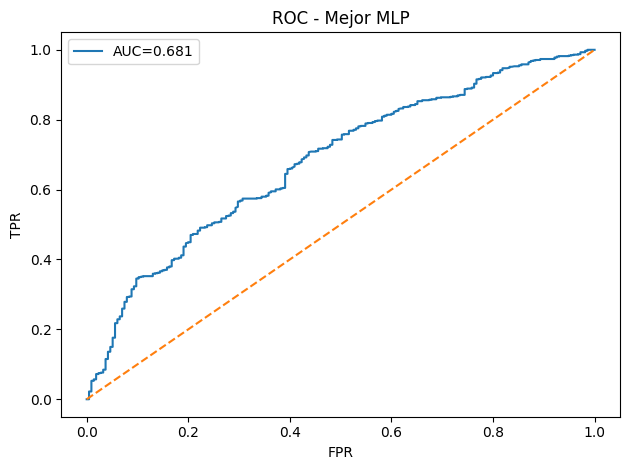

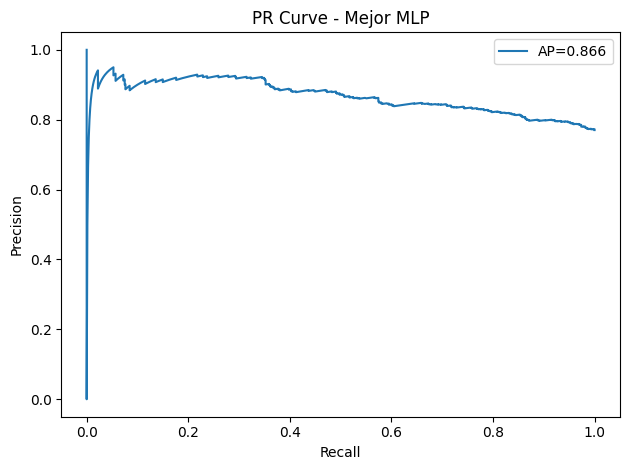

<Figure size 640x480 with 0 Axes>

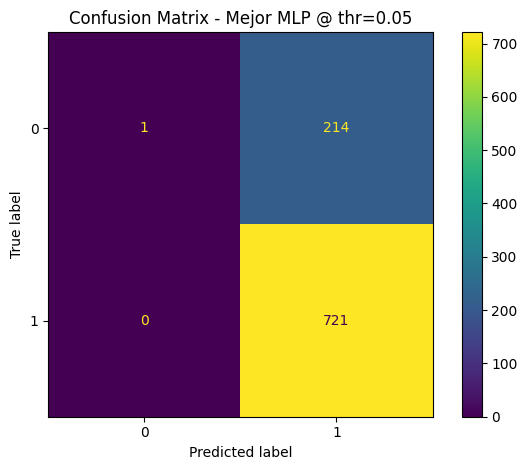

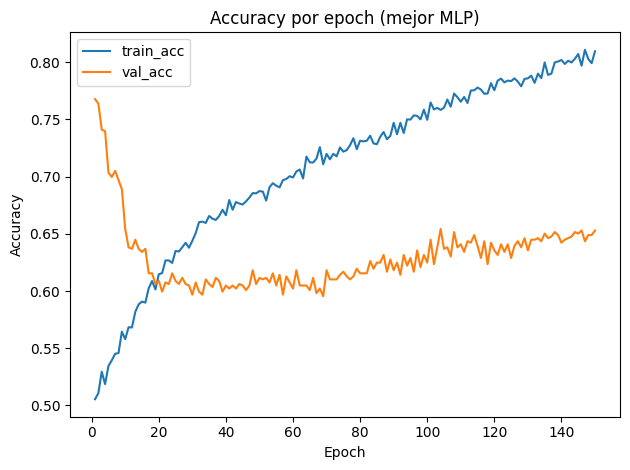

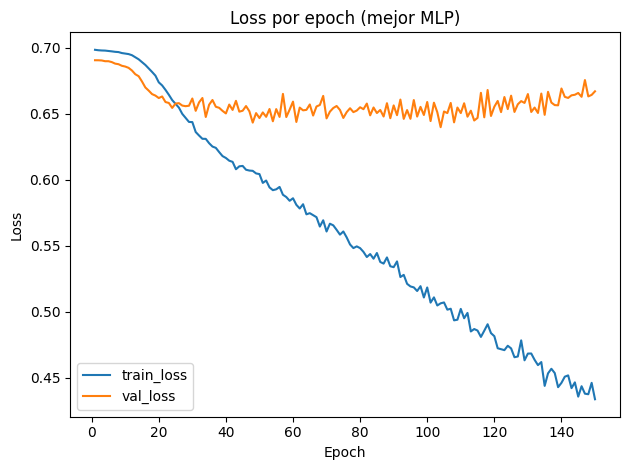


Imágenes guardadas en: C:\Users\pc\Documents\Proyecto Final\notebooks\artifacts


In [20]:
# === EVALUACIÓN EN TEST DEL MEJOR MLP (CPU) + ROC/PR/CM + (opcional) ACC/LOSS ===
import numpy as np, matplotlib.pyplot as plt, json, torch, torch.nn as nn
from pathlib import Path
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

OUT = Path("artifacts"); OUT.mkdir(exist_ok=True)

# ---------- Cargar X_test y y_test ----------
X_te_tx  = np.load(OUT / "X_te_tx.npy")
y_test   = np.load(OUT / "y_test.npy")

# ---------- Helper de modelo (para reconstruir si cargamos de disco) ----------
class MLP(nn.Module):
    def __init__(self, d_in, hidden_layers=(128,), dropout=0.3, act="relu", batchnorm=False):
        super().__init__()
        act_map = {"relu": nn.ReLU, "gelu": nn.GELU, "leakyrelu": lambda: nn.LeakyReLU(0.1)}
        A = act_map[act]
        layers, last = [], d_in
        for h in hidden_layers:
            layers.append(nn.Linear(last, h))
            if batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(A())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last = h
        layers.append(nn.Linear(last, 1))  # logit
        self.net = nn.Sequential(*layers)
    def forward(self, x): 
        return self.net(x).squeeze(1)

# ---------- Obtener best_model y (opcional) best_hist ----------
device = torch.device("cpu")

def load_best_from_disk():
    pt = OUT / "nn_best_search.pt"
    if not pt.exists():
        return None, None, None
    ckpt = torch.load(pt, map_location=device)
    input_dim = ckpt.get("input_dim", X_te_tx.shape[1])
    cfg = ckpt.get("best_cfg", {"hidden_layers":[128], "dropout":0.3, "activation":"relu", "batchnorm":False})
    model = MLP(
        d_in=input_dim,
        hidden_layers=cfg.get("hidden_layers",[128]),
        dropout=cfg.get("dropout",0.3),
        act=cfg.get("activation","relu"),
        batchnorm=cfg.get("batchnorm",False)
    ).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    return model, cfg, None  # no tenemos hist si venimos de disco

# Usa el que está en memoria si existe; si no, intenta cargar de disco
try:
    best_model
    have_memory_model = True
except NameError:
    have_memory_model = False

if have_memory_model:
    model = best_model.to(device).eval()
    try:
        _ = best_cfg
    except NameError:
        best_cfg = None
    try:
        _ = best_hist
    except NameError:
        best_hist = None
else:
    model, best_cfg, best_hist = load_best_from_disk()
    if model is None:
        raise RuntimeError("No encuentro un modelo entrenado. Ejecuta antes la celda de búsqueda (random search) o guarda nn_best_search.pt.")

# ---------- Scores y predicciones ----------
with torch.no_grad():
    scores = torch.sigmoid(model(torch.tensor(X_te_tx, dtype=torch.float32, device=device))).cpu().numpy().reshape(-1)

# baseline @0.5
y_pred_05 = (scores >= 0.5).astype(int)

# Umbral óptimo por F1 (barrido simple)
ths = np.linspace(0.05, 0.95, 19)
f1s = [metrics.f1_score(y_test, (scores >= t).astype(int)) for t in ths]
t_opt = ths[int(np.argmax(f1s))]
y_pred_opt = (scores >= t_opt).astype(int)

# ---------- Métricas resumen ----------
summary = {
    "test_auc": float(metrics.roc_auc_score(y_test, scores)),
    "test_ap": float(metrics.average_precision_score(y_test, scores)),
    "f1@0.5": float(metrics.f1_score(y_test, y_pred_05)),
    "precision@0.5": float(metrics.precision_score(y_test, y_pred_05)),
    "recall@0.5": float(metrics.recall_score(y_test, y_pred_05)),
    "thr_opt_f1": float(t_opt),
    "f1@opt": float(metrics.f1_score(y_test, y_pred_opt)),
    "precision@opt": float(metrics.precision_score(y_test, y_pred_opt)),
    "recall@opt": float(metrics.recall_score(y_test, y_pred_opt)),
}
print("Resumen test (mejor MLP):")
for k, v in summary.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ---------- Gráfica ROC ----------
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
auc = metrics.roc_auc_score(y_test, scores)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Mejor MLP")
plt.legend()
plt.tight_layout()
plt.savefig(OUT / "nn_best_cpu_roc.png", dpi=160)
plt.show()

# ---------- Gráfica Precision–Recall ----------
prec, rec, _ = metrics.precision_recall_curve(y_test, scores)
ap = metrics.average_precision_score(y_test, scores)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Mejor MLP")
plt.legend()
plt.tight_layout()
plt.savefig(OUT / "nn_best_cpu_pr.png", dpi=160)
plt.show()

# ---------- Matriz de confusión (umbral óptimo) ----------
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)
plt.title(f"Confusion Matrix - Mejor MLP @ thr={t_opt:.2f}")
plt.tight_layout()
plt.savefig(OUT / f"nn_best_cpu_cm_thr{t_opt:.2f}.png", dpi=160)
plt.show()

# ---------- (Opcional) Curvas de accuracy/loss si best_hist está en memoria ----------
if "best_hist" in globals() and best_hist is not None and isinstance(best_hist, dict) and "epoch" in best_hist:
    epochs = best_hist["epoch"]
    # Accuracy
    plt.figure()
    plt.plot(epochs, best_hist["train_acc"], label="train_acc")
    plt.plot(epochs, best_hist["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy por epoch (mejor MLP)")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT / "nn_best_cpu_acc.png", dpi=160); plt.show()

    # Loss
    plt.figure()
    plt.plot(epochs, best_hist["train_loss"], label="train_loss")
    plt.plot(epochs, best_hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss por epoch (mejor MLP)")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT / "nn_best_cpu_loss.png", dpi=160); plt.show()
else:
    print("\n(Nota) No hay 'best_hist' en memoria; omito curvas de accuracy/loss. Si quieres guardarlas, conserva 'best_hist' al finalizar la búsqueda.")

print(f"\nImágenes guardadas en: {OUT.resolve()}")
